In [1]:
'''coding envrionment Python 3.5'''
## common packages
import os, sys, importlib
# from __future__ import division # if you want to use python 2.x
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## machine learning packages
from sklearn.ensemble import GradientBoostingClassifier #GBC algorithm
from sklearn import linear_model, cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

## in-house library
import Ensemble_library as ES
from Ensemble_tuned_parameters import *
ES = importlib.reload(ES)

In [2]:
## read the data
vectors = pd.read_csv(verb_file,index_col=0)
#print(vectors.head())

# filter out the Nan's and take/not to take the middle ROEs
if drop_middle_thrid:
    vectors_filtered = vectors[vectors['Label']!=2].dropna()
else:
    vectors_filtered = vectors.dropna()

## add 2 more columns of the sign of the change
vectors_filtered['ROE_excess_change_sign'] = vectors_filtered['ROE_excess_change']>0
vectors_filtered['ROE_change_sign'] = vectors_filtered['ROE_change']>0

## check if there is any missing data
assert vectors_filtered.isnull().sum().sum() == 0, "there are some na's in df vectors_filtered"

## how big is our super cleaned data
print(vectors_filtered.shape)
m = len(vectors_filtered)

colnames = vectors_filtered.columns.values
#colnames

(23005, 339)


In [3]:
## we augment the bm model by 300 features
predictors = np.append(colnames[3:303], predictors_bm)

## shuffle the data and take out 10% of data
np.random.seed(seed)
vectors_filtered_shuffled = vectors_filtered.iloc[np.random.permutation(len(vectors_filtered))].reset_index(drop=True)

test_data = vectors_filtered_shuffled.iloc[:int(m*test_portion)]
train_valid_data = vectors_filtered_shuffled.iloc[int(m*test_portion):]

## check if we slice correctly
assert len(test_data)+ len(train_valid_data) == m 

In [5]:
# we want to make sure the % of +'s and -'s are close
# otherwise we need to rebalance
(vectors_filtered_shuffled[y]>0).sum()/len(vectors_filtered_shuffled)

0.45429254509889155

In [6]:
gbt_bm = GradientBoostingClassifier(**GBT_bm_params)
gbt_bm.fit(train_valid_data[predictors_bm],train_valid_data[y])

GradientBoostingClassifier(init=None, learning_rate=0.026674999999999997,
              loss='deviance', max_depth=5, max_features=9,
              max_leaf_nodes=None, min_samples_leaf=30,
              min_samples_split=1000, min_weight_fraction_leaf=0.0,
              n_estimators=1200, presort='auto', random_state=10,
              subsample=0.85, verbose=0, warm_start=False)


Model Report
Accuracy : 0.7319
AUC Score (Train): 0.817823
CV Score : Mean - 0.7895545 | Std - 0.002741037 | Min - 0.7850705 | Max - 0.793487


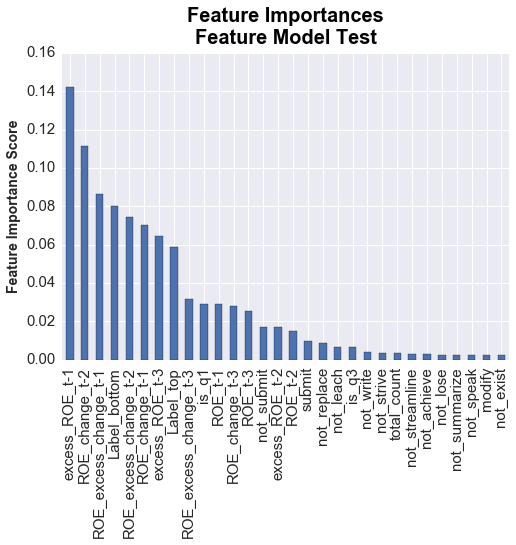

In [8]:
gbt_cv_glimps1 = GradientBoostingClassifier(random_state=10)
ES.modelfit(gbt_cv_glimps1, train_valid_data, predictors, y, model_name="Feature Model Test")

In [9]:
learning_rate = 0.5335

## this grid search pick n_estimators
min_samples_split = 0.01*len(vectors_filtered) ## make it 1% of the data
param_test1 = {'n_estimators': list(range(20,101,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
    min_samples_split=min_samples_split,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_valid_data[predictors],train_valid_data[y])

print("Here we set min_samples_split={}, and tune n_estimators".format(min_samples_split))

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Here we set min_samples_split=230.05, and tune n_estimators


([mean: 0.75224, std: 0.00882, params: {'n_estimators': 20},
  mean: 0.75473, std: 0.00624, params: {'n_estimators': 30},
  mean: 0.75675, std: 0.00387, params: {'n_estimators': 40},
  mean: 0.75662, std: 0.00370, params: {'n_estimators': 50},
  mean: 0.75662, std: 0.00478, params: {'n_estimators': 60},
  mean: 0.75677, std: 0.00423, params: {'n_estimators': 70},
  mean: 0.75830, std: 0.00526, params: {'n_estimators': 80},
  mean: 0.75796, std: 0.00471, params: {'n_estimators': 90},
  mean: 0.75791, std: 0.00361, params: {'n_estimators': 100}],
 {'n_estimators': 80},
 0.75829855412878033)

In [10]:
## this grid search pick max_depth and min_samples_split
n_estimators = gsearch1.best_params_['n_estimators'] ## from previous grid
param_test2 = {'max_depth':list(range(5,16,2)), 'min_samples_split': list(range(200,1001,200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,\
    n_estimators = n_estimators, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_valid_data[predictors],train_valid_data[y])

print("Here we set n_estimators={}, and tune max_depth and min_samples_split".format(n_estimators))

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Here we set n_estimators=80, and tune max_depth and min_samples_split


([mean: 0.75600, std: 0.00530, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.75566, std: 0.00841, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.75832, std: 0.00804, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.75408, std: 0.00856, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.75812, std: 0.00672, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.75184, std: 0.00430, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.75601, std: 0.00394, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.76059, std: 0.00499, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.75754, std: 0.00144, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.75796, std: 0.00532, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.74652, std: 0.00527, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.75048, std: 0.00566, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [11]:
## this grid search pick min_samples_split and min_samples_leaf

max_depth = gsearch2.best_params_['max_depth']

param_test3 = {'min_samples_split':list(range(1000,2100,200)), 'min_samples_leaf': list(range(30,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate= learning_rate,\
        n_estimators=n_estimators, max_depth= max_depth,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_valid_data[predictors],train_valid_data[y])


print("Here we set max_depth={}, and tune min_samples_split and min_samples_leaf".format(max_depth))

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_


Here we set max_depth=7, and tune min_samples_split and min_samples_leaf


([mean: 0.76179, std: 0.00606, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.76037, std: 0.00710, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.76182, std: 0.00669, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.76294, std: 0.00872, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.76009, std: 0.00500, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.76207, std: 0.00775, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.76114, std: 0.00568, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.76380, std: 0.00513, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.75932, std: 0.00466, params: {'min_samples_leaf': 40, 'min_samples_split': 1400},
  mean: 0.76253, std: 0.00848, params: {'min_samples_leaf': 40, 'min_samples_split': 1600},
  mean: 0.76352, std: 0.00707, params: {'min_samples_leaf': 40, 'min_samples_spl

In [12]:
## this grid search pick max_features
min_samples_leaf = gsearch3.best_params_['min_samples_leaf']
min_samples_split = gsearch3.best_params_['min_samples_split']

param_test4 = {'max_features': list(range(7,30,2))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
        n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, subsample=0.8, random_state=10),
        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_valid_data[predictors],train_valid_data[y])


print("Here we set min_samples_leaf={} and min_samples_split={}, and tune max_features"
      .format(min_samples_leaf,min_samples_split))

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Here we set min_samples_leaf=60 and min_samples_split=1000, and tune max_features


([mean: 0.74646, std: 0.00593, params: {'max_features': 7},
  mean: 0.75587, std: 0.00441, params: {'max_features': 9},
  mean: 0.75815, std: 0.00750, params: {'max_features': 11},
  mean: 0.75911, std: 0.00436, params: {'max_features': 13},
  mean: 0.76373, std: 0.00304, params: {'max_features': 15},
  mean: 0.76625, std: 0.00871, params: {'max_features': 17},
  mean: 0.76307, std: 0.00589, params: {'max_features': 19},
  mean: 0.76991, std: 0.00201, params: {'max_features': 21},
  mean: 0.76934, std: 0.00459, params: {'max_features': 23},
  mean: 0.77004, std: 0.00421, params: {'max_features': 25},
  mean: 0.76994, std: 0.00395, params: {'max_features': 27},
  mean: 0.76760, std: 0.00685, params: {'max_features': 29}],
 {'max_features': 25},
 0.77004222063396777)

In [13]:
## this grid search pick subsample

max_features = gsearch4.best_params_['max_features']

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 =  GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
        n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, max_features = max_features, random_state=10),
        param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_valid_data[predictors],train_valid_data[yInput: 
clearn_excess_roe_sp500v1.csv. This file contains ROE for each firm as well as S&P500 ROE. These data are extracted from Bloomberg terminal. This file was provided by Eric Li and no change was made when read in to Python.

Description: 
For all of firms, checked the stationarity of ROE, the changes of ROE (ROE_d), excess ROE over the S&P500 (ROE_e), and the changes of excess ROE (ROE_e_d).

Here are the key findings:
-Generally speaking, most firm's ROE failed the ADF test for stationarity. (355/489 firms have p-value > 5%, failed the test. Recall that the null hypothesis of ADF test is the time-series has an unit root. Thus, the smaller the p-value, the more confidence to reject the null, and hence the time-series is stationary).

-After take the first differencing, most firm's changes in ROE passed the ADF test. (431/487 firms passed the test. We are missing two firms here because we loss one data point when taking the first differencing, and there is a minimum #observation requirement for python's ADF test).

-Similar observations for excess ROE and the first difference for excess ROE.

-The time-series plots provide strong visual effects. Indeed, ROE looks more like a random walk, whereas changes of ROE looks more stationary.

Output:
The output includes 4 excel files, which each contains the ADF test and p-value and whether the p-value is greater than 5%. 
The output also includes 4 pdf files, which each contains the time-series plots for ROE, ROE_d, ROE_e, ROE_d_e respectively for every firm.

Key decision made:
Based on this test, the team concluded ROEs in general are not stationary. Thus, instead of using previous level of ROE and predicting future level of ROE, the team now focus on predicting changes of ROE.
])

print("Here we set max_features={}, and tune subsample".format(max_features))

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Here we set max_features=25, and tune subsample


([mean: 0.75705, std: 0.00723, params: {'subsample': 0.6},
  mean: 0.76315, std: 0.00609, params: {'subsample': 0.7},
  mean: 0.76327, std: 0.00419, params: {'subsample': 0.75},
  mean: 0.77004, std: 0.00421, params: {'subsample': 0.8},
  mean: 0.76846, std: 0.00481, params: {'subsample': 0.85},
  mean: 0.77121, std: 0.00543, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 0.77121304319800343)

In [14]:
subsample = gsearch5.best_params_['subsample']
print('learning_rate =',learning_rate, ', n_estimators =', n_estimators)

learning_rate = 0.5335 , n_estimators = 80



Model Report
Accuracy : 0.8289
AUC Score (Train): 0.912937
CV Score : Mean - 0.7943271 | Std - 0.005215877 | Min - 0.7855869 | Max - 0.8006043


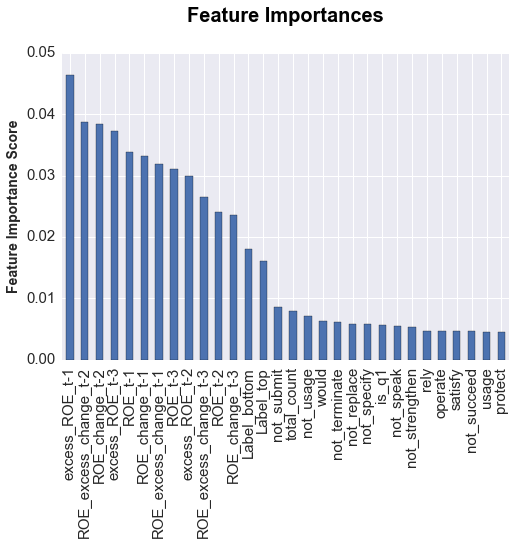

In [15]:
# Now lets reduce to one-twentieth of the original value
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=learning_rate/20, n_estimators=n_estimators*20,
            max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, subsample=subsample, 
            random_state=10, max_features=max_features)

ES.modelfit(gbm_tuned_3, train_valid_data, predictors, y)

In [16]:
gbm_tuned_3.get_params()

{'init': None,
 'learning_rate': 0.026674999999999997,
 'loss': 'deviance',
 'max_depth': 7,
 'max_features': 25,
 'max_leaf_nodes': None,
 'min_samples_leaf': 60,
 'min_samples_split': 1000,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1600,
 'presort': 'auto',
 'random_state': 10,
 'subsample': 0.9,
 'verbose': 0,
 'warm_start': False}

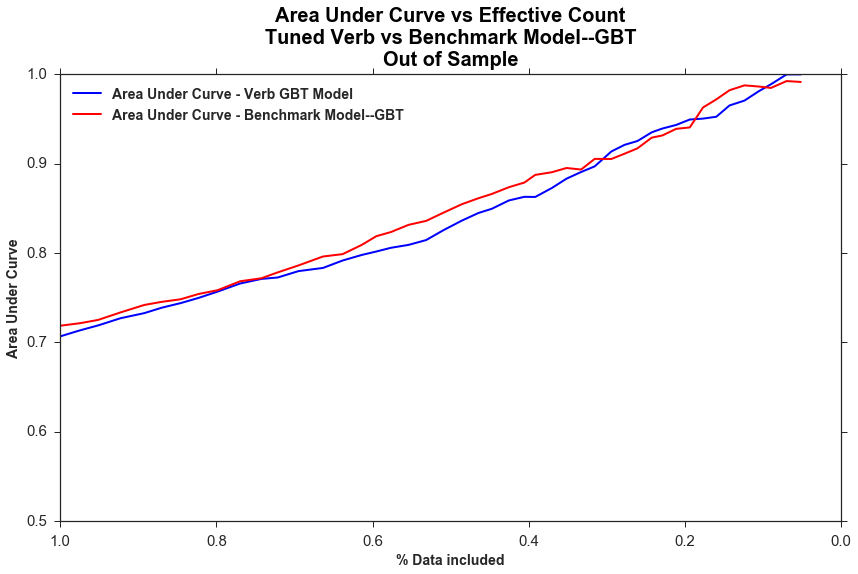

In [17]:
ES.AUCvsCountsPlot(gbm_tuned_3, test_data, predictors, y, 
                       model_name="Verb GBT Model", alg2=gbt_bm, dtest2=test_data,
                       predictors2=predictors_bm, y2=y, model_name2="Benchmark Model--GBT",
                       title_second_line = "Tuned Verb vs Benchmark Model--GBT\nOut of Sample")